In [4]:
import os
import re
import matplotlib.pyplot as plt

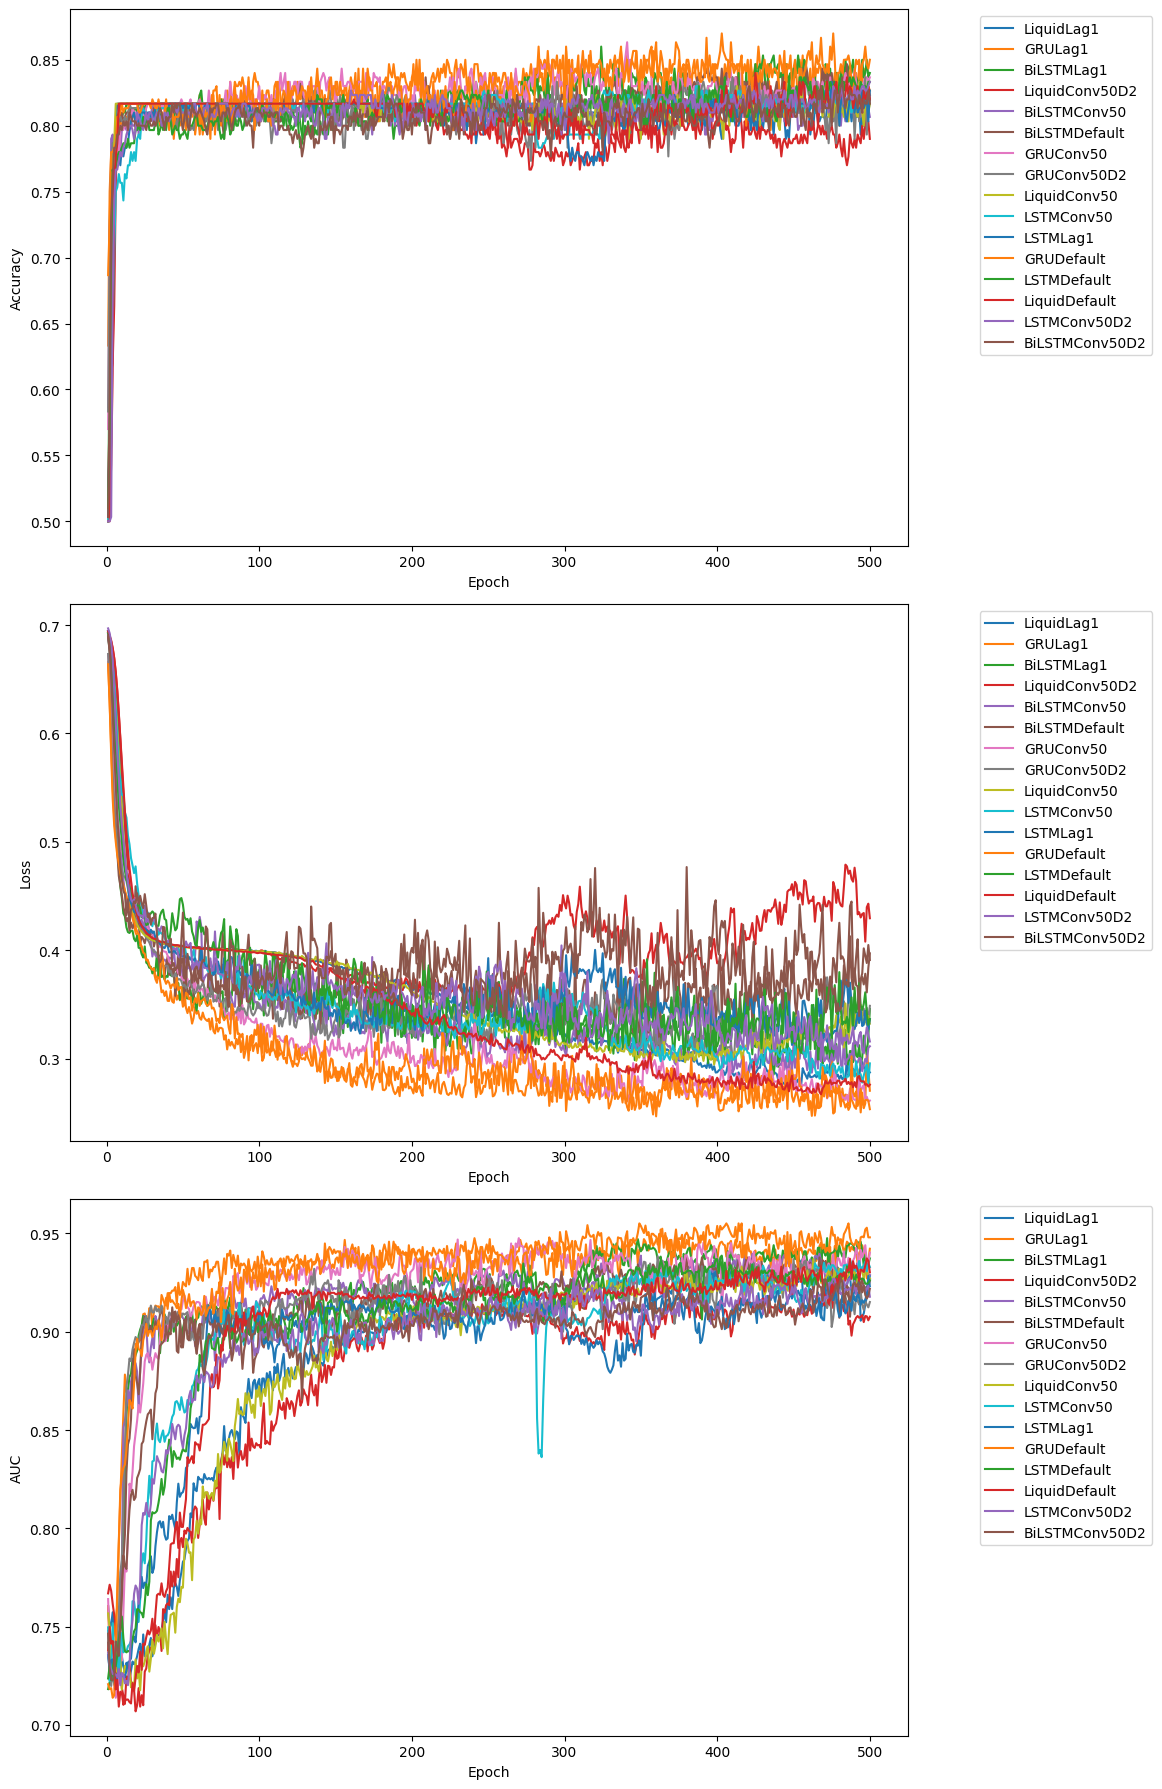

In [18]:
def extract_metrics_from_file(file_path):
    all_epochs = []
    all_accuracy = []
    all_loss = []
    all_auc = []
    
    with open(file_path, 'r') as f:
        for line in f:
            match = re.match(r"Epoch (\d+): ACC = ([\d\.]+) LOSS = ([\d\.]+) AUC = ([\d\.]+)", line)
            if match:
                epoch, acc, loss, auc = match.groups()
                all_epochs.append(int(epoch))
                all_accuracy.append(float(acc))
                all_loss.append(float(loss))
                all_auc.append(float(auc))
    
    return all_epochs, all_accuracy, all_loss, all_auc

def plot_metrics(log_folder, read_file, model_prefix, model_suffix):
    all_epochs, all_acc, all_loss, all_auc = [], [], [], []
    file_names = []

    for model_folder in os.listdir(log_folder):
        model_path = os.path.join(log_folder, model_folder)
        if model_folder.startswith(model_prefix) and model_folder.endswith(model_suffix):
            for file_name in os.listdir(model_path):
                if file_name.endswith(".txt") and file_name == read_file:
                    file_path = os.path.join(model_path, file_name)

                    epochs, acc, loss, auc = extract_metrics_from_file(file_path)
                    all_epochs.append(epochs)
                    all_acc.append(acc)
                    all_loss.append(loss)
                    all_auc.append(auc)
                    file_names.append(model_folder)
    
    plt.figure(figsize=(12, 18))
    
    plt.subplot(3, 1, 1)
    for i in range(len(all_epochs)):
        plt.plot(all_epochs[i], all_acc[i], label=file_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
    plt.subplot(3, 1, 2)
    for i in range(len(all_epochs)):
        plt.plot(all_epochs[i], all_loss[i], label=file_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
    plt.subplot(3, 1, 3)
    for i in range(len(all_epochs)):
        plt.plot(all_epochs[i], all_auc[i], label=file_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
    plt.tight_layout()
    plt.show()

results_folder = "../../results"
read_file = "test.txt"
model_prefix = ""
model_suffix = ""

plot_metrics(results_folder, read_file, model_prefix, model_suffix)

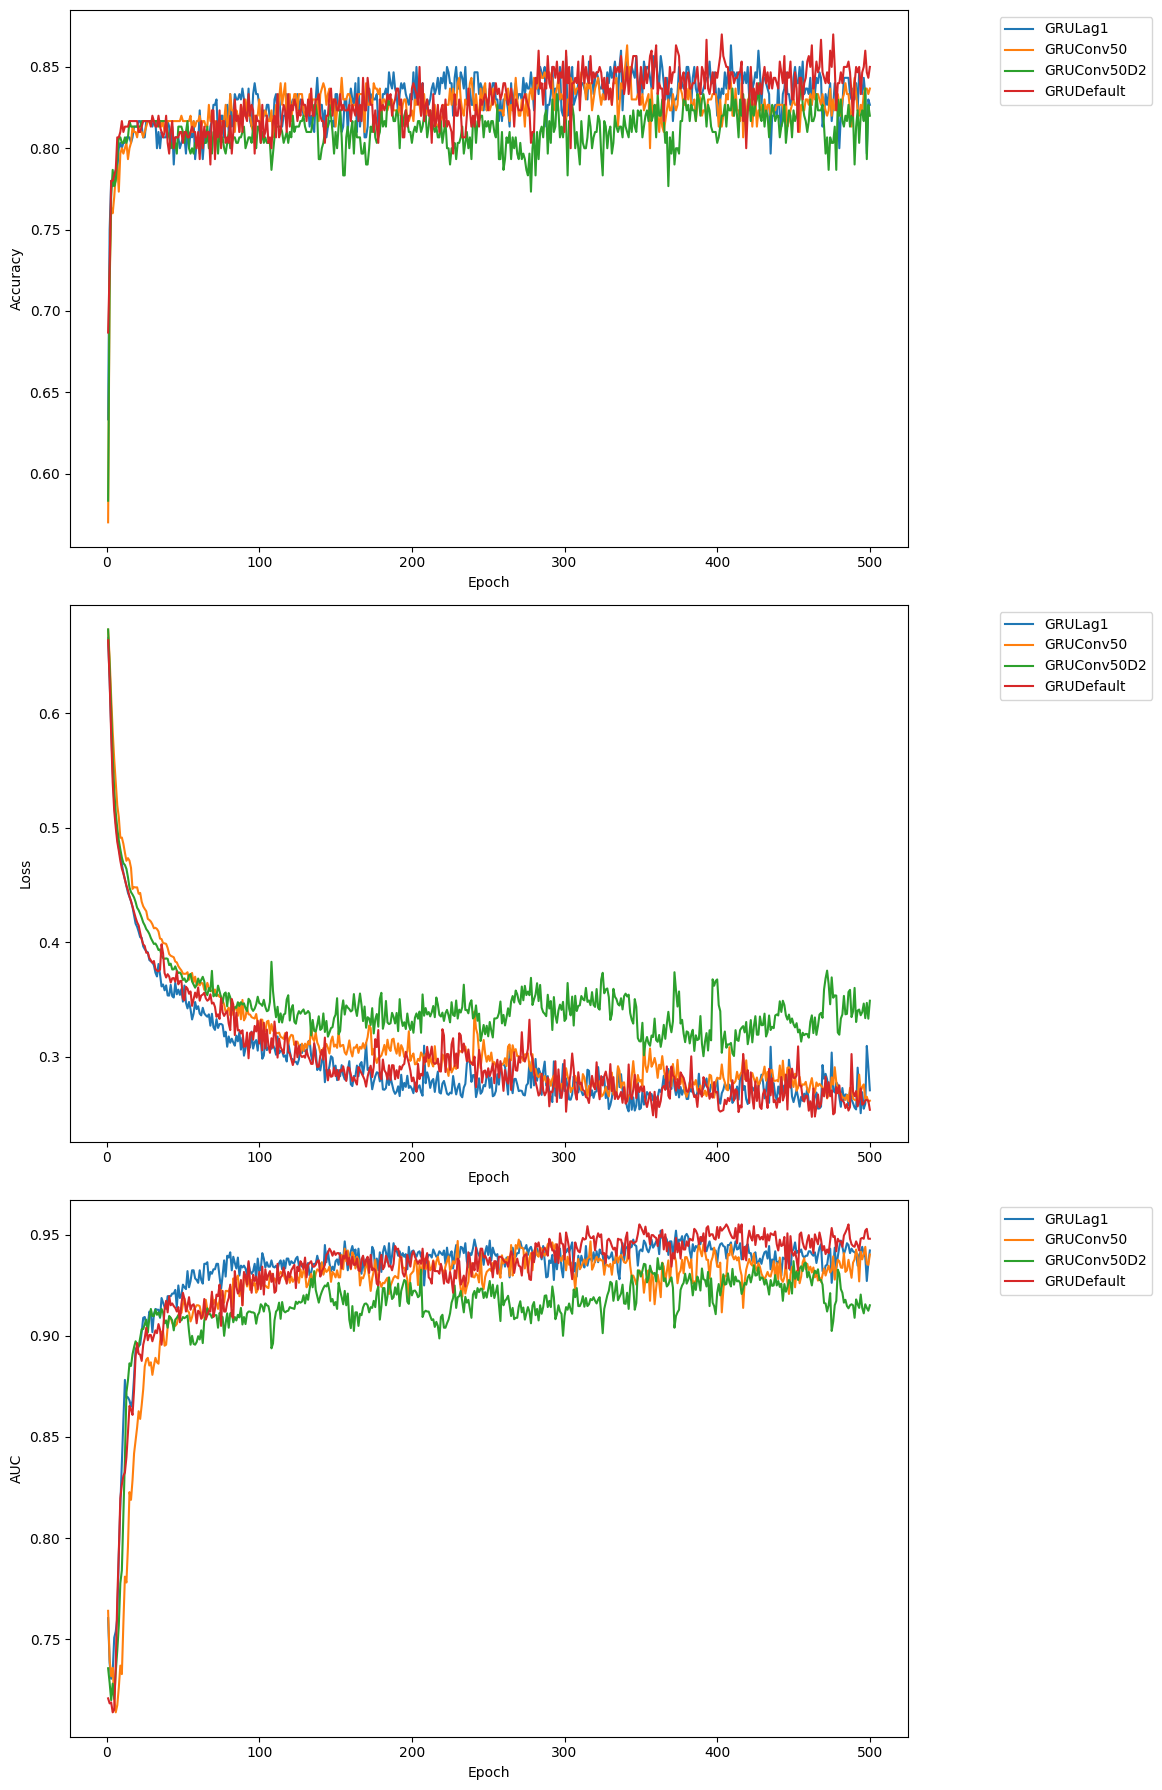

In [19]:
results_folder = "../../results"
read_file = "test.txt"
model_prefix = "GRU"
model_suffix = ""

plot_metrics(results_folder, read_file, model_prefix, model_suffix)

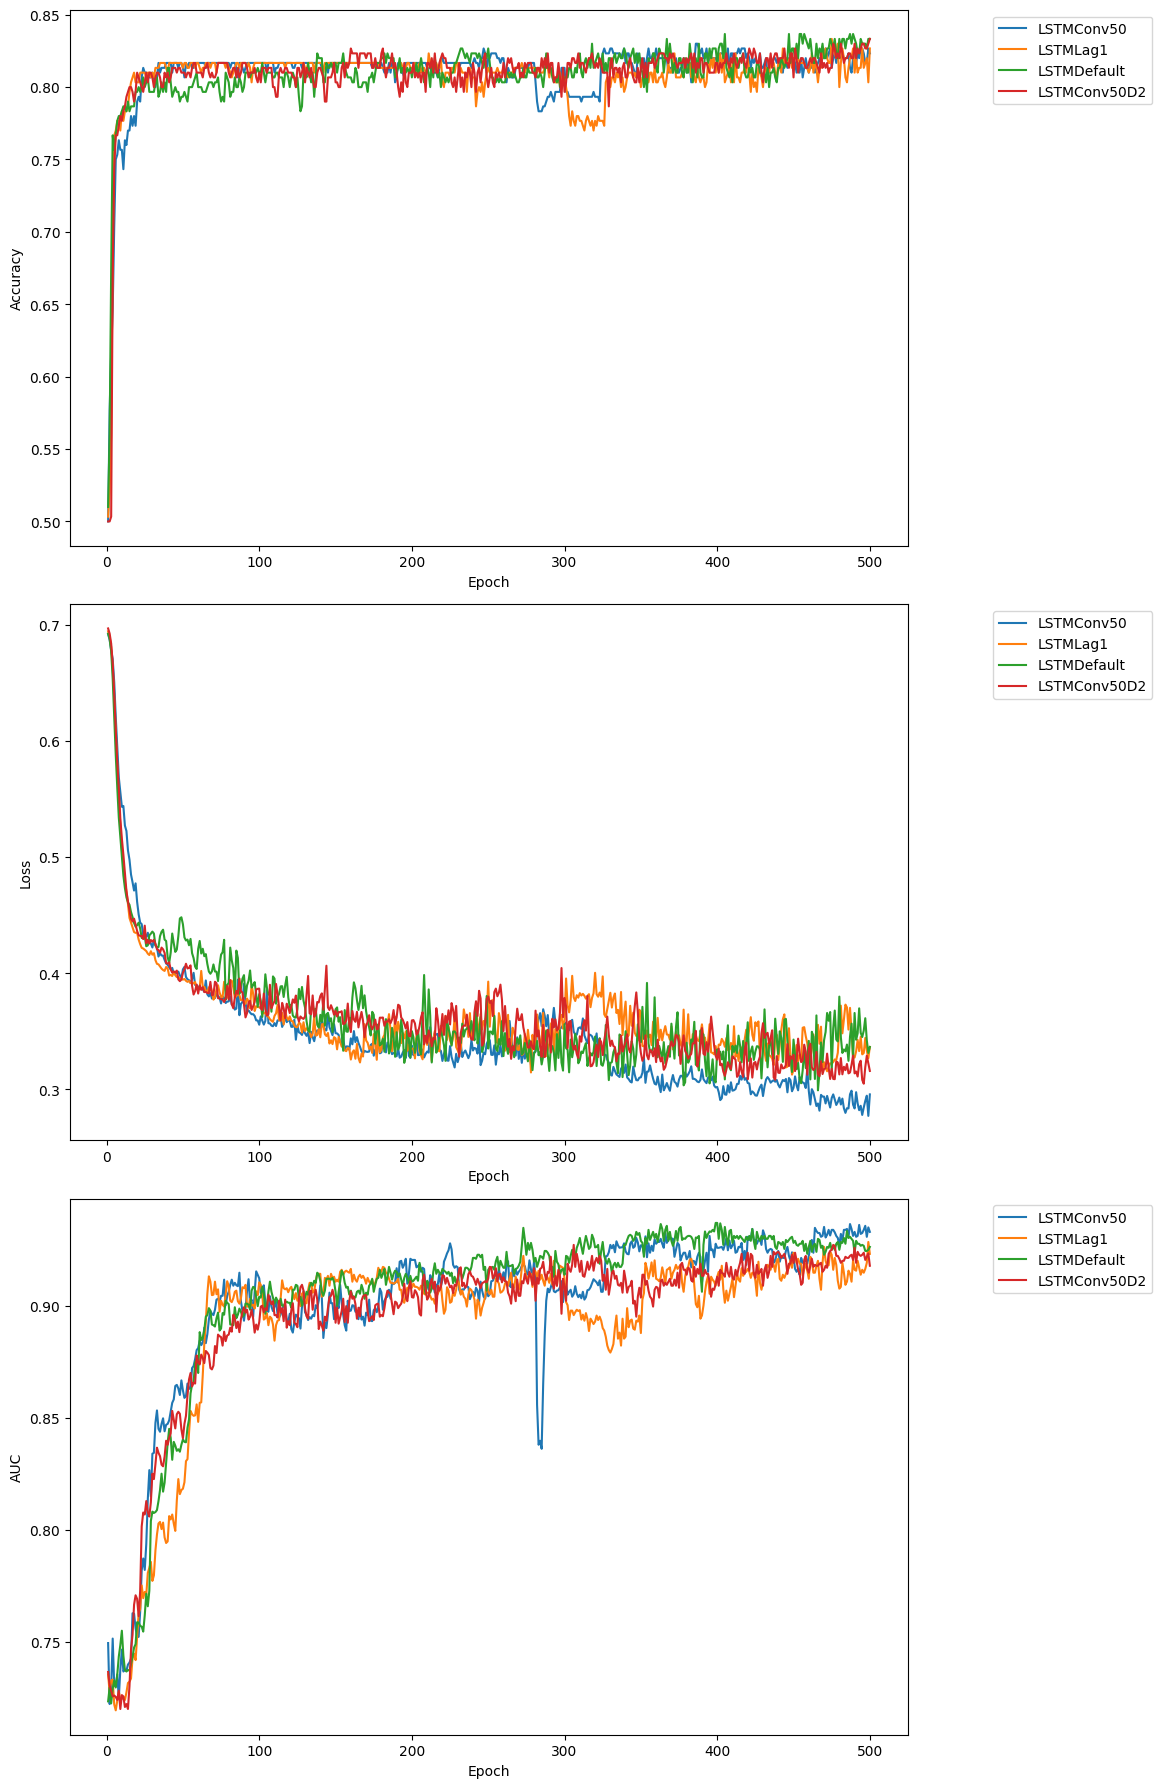

In [20]:
results_folder = "../../results"
read_file = "test.txt"
model_prefix = "LSTM"
model_suffix = ""

plot_metrics(results_folder, read_file, model_prefix, model_suffix)

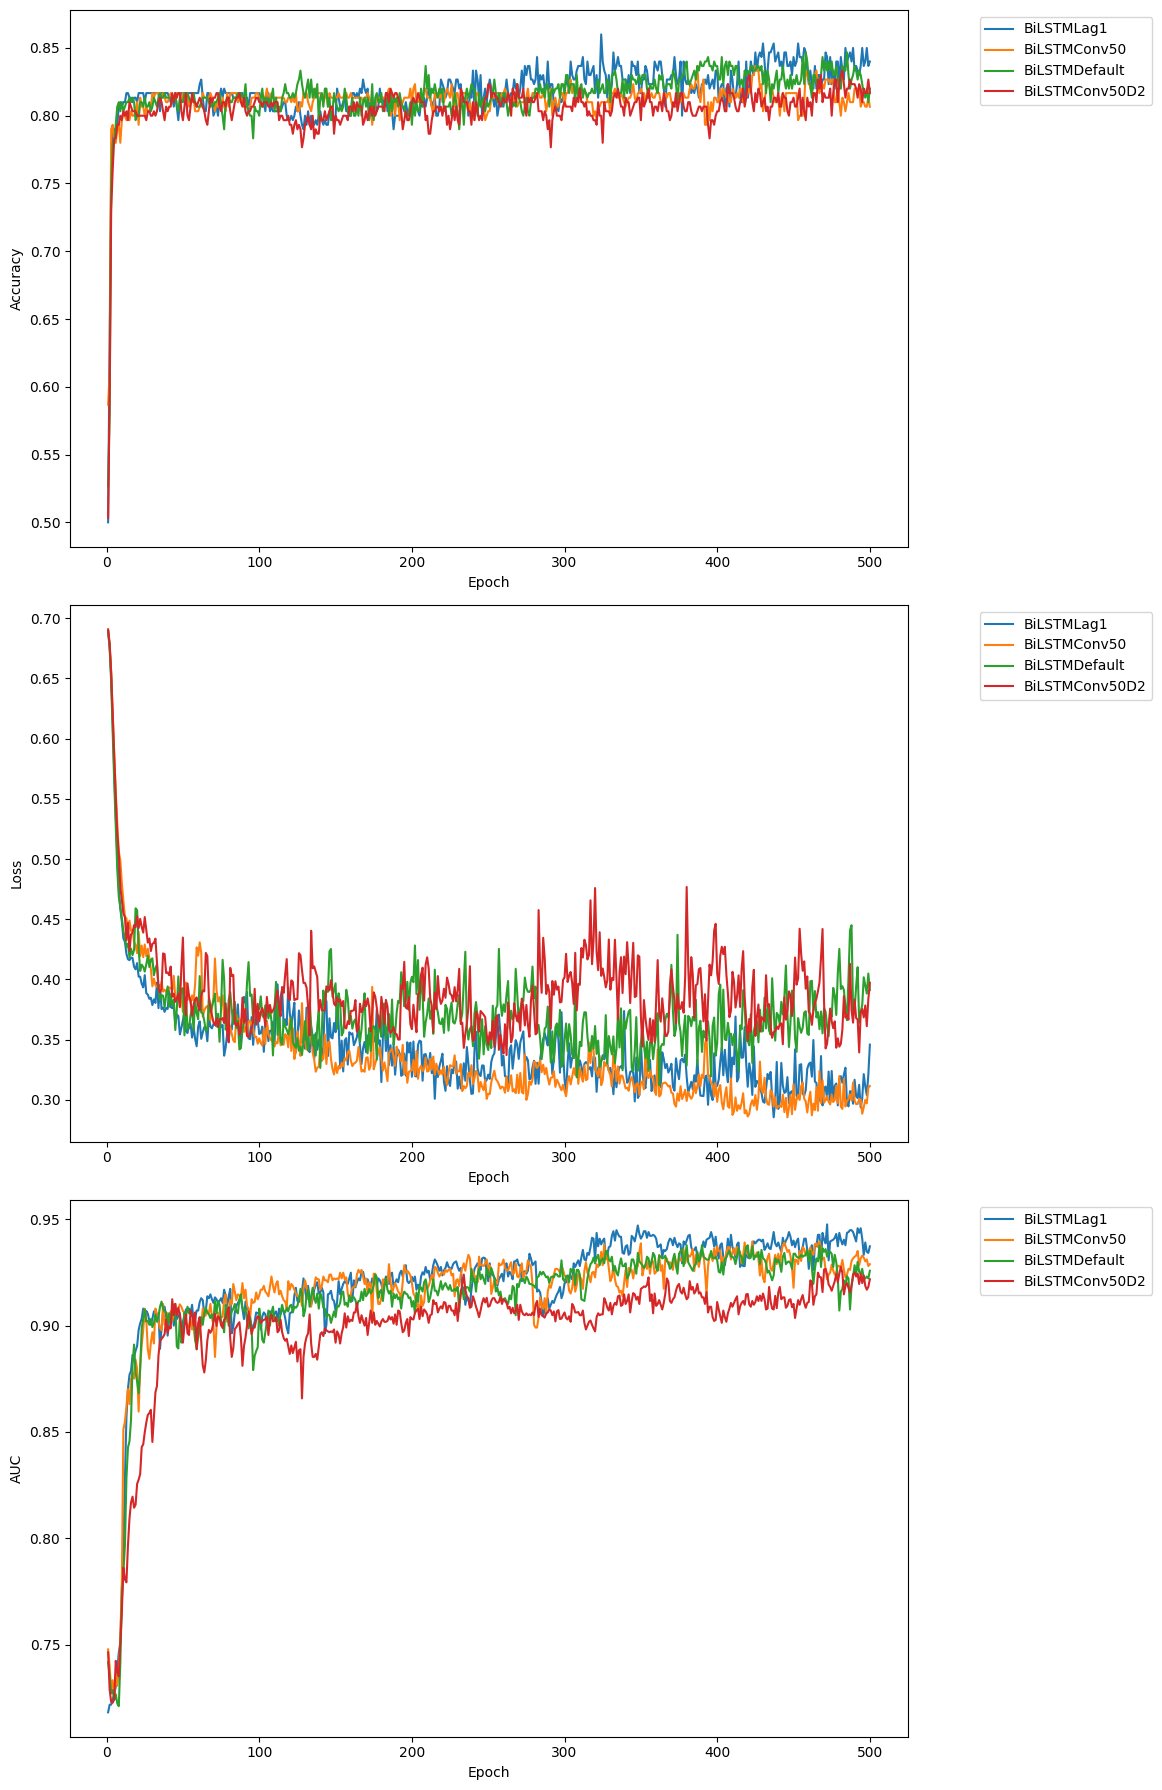

In [21]:
results_folder = "../../results"
read_file = "test.txt"
model_prefix = "BiLSTM"
model_suffix = ""

plot_metrics(results_folder, read_file, model_prefix, model_suffix)

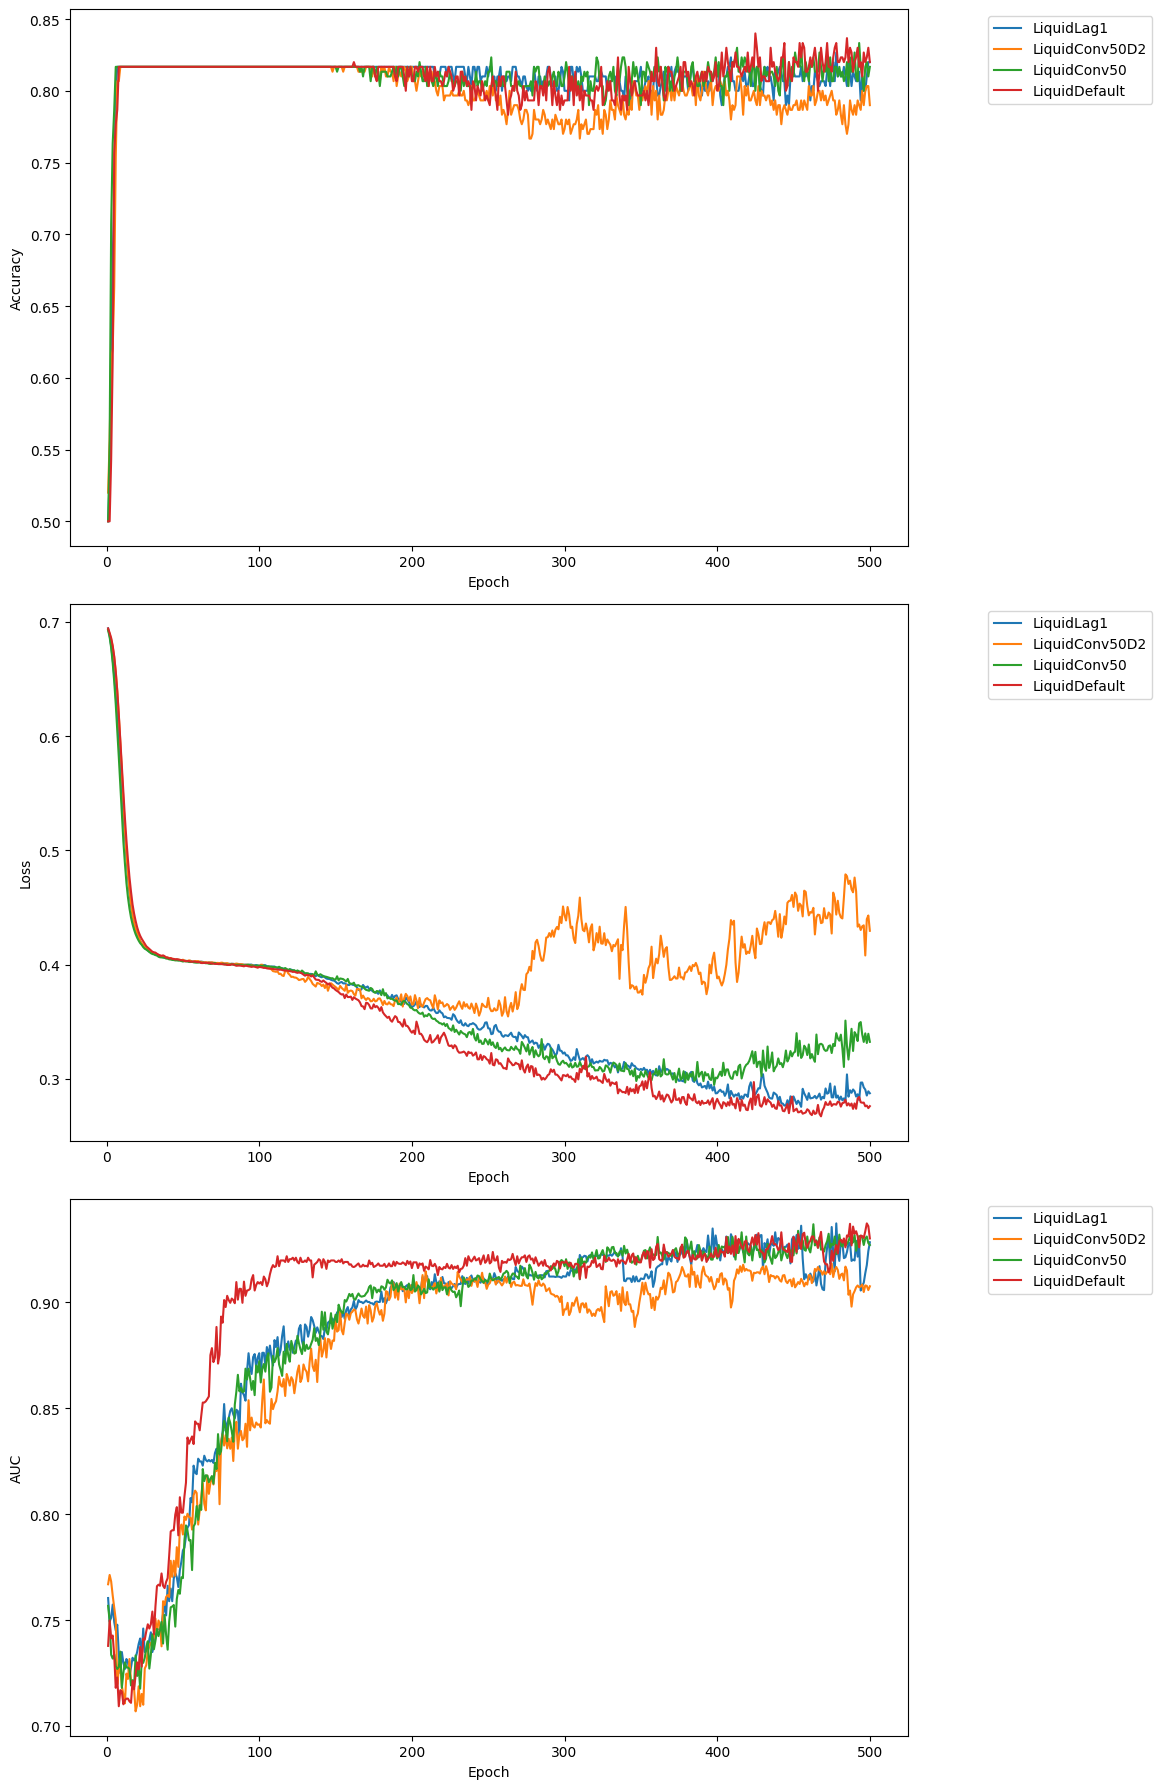

In [22]:
results_folder = "../../results"
read_file = "test.txt"
model_prefix = "Liquid"
model_suffix = ""

plot_metrics(results_folder, read_file, model_prefix, model_suffix)